## GeoPoint

In [2]:
import pandas as pd
import chardet

# https://simplemaps.com/data/us-cities

# Determine the encoding of the file
with open("../../data/uscities.csv", 'rb') as f:
    result = chardet.detect(f.read())
encoding = result['encoding']

print("File encoding:", encoding)

df = pd.read_csv("../../data/uscities.csv", encoding=encoding)
df['LATITUDE'] = df['lat'].astype(float)
df['LONGITUDE'] = df['lng'].astype(float)
df["GeoJSON"] = df.apply(lambda x: {"type": "Point", "coordinates": [x["LONGITUDE"], x["LATITUDE"]]}, axis=1)
RENAME_COLUMNS = {"city": "CITY", "state_id": "STATE_CODE","id":"ID"}
df.rename(columns=RENAME_COLUMNS,inplace=True)
NEEDED_COLUMNS = ["ID","CITY", "STATE_CODE","GeoJSON"]
df.info()
print(df.head(1))
df = df[NEEDED_COLUMNS]

File encoding: utf-8
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31120 entries, 0 to 31119
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CITY          31120 non-null  object 
 1   city_ascii    31120 non-null  object 
 2   STATE_CODE    31120 non-null  object 
 3   state_name    31120 non-null  object 
 4   county_fips   31120 non-null  int64  
 5   county_name   31120 non-null  object 
 6   lat           31120 non-null  float64
 7   lng           31120 non-null  float64
 8   population    31120 non-null  int64  
 9   density       31120 non-null  float64
 10  source        31120 non-null  object 
 11  military      31120 non-null  bool   
 12  incorporated  31120 non-null  bool   
 13  timezone      31120 non-null  object 
 14  ranking       31120 non-null  int64  
 15  zips          31118 non-null  object 
 16  ID            31120 non-null  int64  
 17  LATITUDE      31120 non-null  float64
 18  LONGI

In [3]:
from opensearchpy import OpenSearch, helpers  # Import the OpenSearch client and helpers module

def bulk_load_documents(os_client: OpenSearch, index_name: str, documents: list) -> None:
    """
    Bulk loads a list of documents into OpenSearch.
    Parameters:
    - os_client (OpenSearch): The OpenSearch client instance.
    - index_name (str): The name of the index where the documents will be inserted.
    - documents (list): A list of documents to be inserted into OpenSearch.
    Returns:
    - None
    Raises:
    - None
    """

    try: 
        # Prepare the actions for bulk indexing
        actions = [
            {
                "_index": index_name,
                "_source": doc,
                "_id": doc["ID"]
            }
            for doc in documents
        ]

        # Perform the bulk load
        success, errors = helpers.bulk(os_client, actions, 
                                   index=index_name,
                                   raise_on_error=False,
                                   raise_on_exception=False)
        
        print(f"Successful operations: {success}")
    
        if errors:
            print("Errors encountered:")
            for error in errors:
                print(f"Document ID: {error['index']['_id']}")
                print(f"Error reason: {error['index']['error']['reason']}")
                print("---")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


In [4]:
from opensearchpy import OpenSearch
import json

IS_AUTH = False

if IS_AUTH:
    # Initialize the OpenSearch client
    os_client = OpenSearch(
        hosts=[{'host': '192.168.0.111', 'port': 9200}],
        http_auth=('admin', 'Developer@123'),  # Replace with your credentials
        use_ssl=True,
        verify_certs=False,
        ssl_show_warn=False
    )
else:
    # Initialize the OpenSearch client without authentication
    os_client = OpenSearch(
        hosts=[{'host': '192.168.0.111', 'port': 9200}],
        use_ssl=False,
        verify_certs=False,
        ssl_assert_hostname = False,
        ssl_show_warn=False
    )

# Define the index name
index_name = "points"

# Define the mapping
mapping = {
  "mappings": {
    "properties": {
      "GeoJSON": {
        "type": "geo_point"
      }
    }
  }
}

# Create the index with the specified mapping
os_client.indices.create(index=index_name, body=mapping)

# Bulk load documents into OpenSearch
bulk_load_documents(os_client, index_name, json.loads(df.to_json(orient="records")))


Successful operations: 31120


## Query Geopoint - geo_bounding_box
- 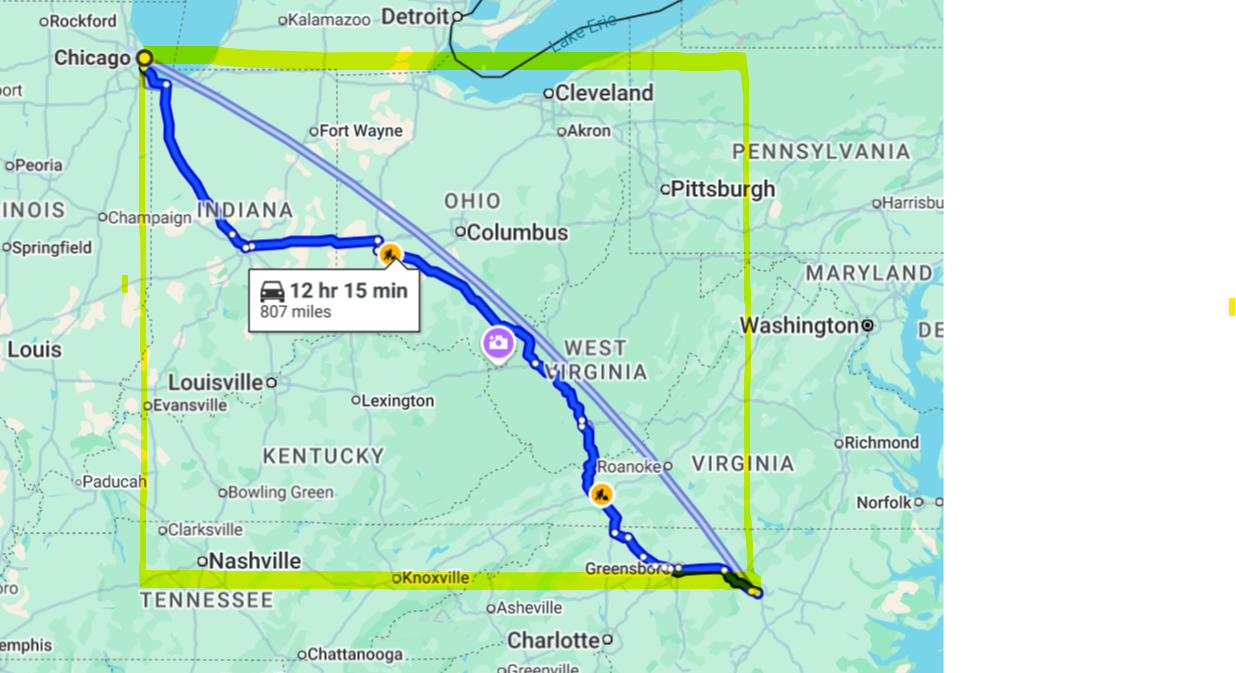

In [ ]:
from IPython.display import display
# chicago to raleigh geo-bounding box

chicago_raleigh_df = df[
  (df['CITY'] == 'Chicago') & (df['STATE_CODE'] == 'IL') |
  (df['CITY'] == 'Raleigh') & (df['STATE_CODE'] == 'NC')
]

# Set display options to show full row contents
pd.set_option('display.max_colwidth', None)
display(chicago_raleigh_df["GeoJSON"])
# Create a geo_bounding_box for Elasticsearch search
geo_bounding_box = {
    "GeoJSON": {
    "top_left": chicago_raleigh_df["GeoJSON"].iloc[0]["coordinates"],
    "bottom_right": chicago_raleigh_df["GeoJSON"].iloc[1]["coordinates"]
}
}

print(geo_bounding_box)

QUERY =  {
  "query": {
    "bool": {
      "must": {
        "match_all": {}
      },
      "filter": {
        "geo_bounding_box": geo_bounding_box
      }
    }
  }
}

search_results = os_client.search(index="points", body=QUERY, error_trace=True)

# Process search results
for hit in search_results["hits"]["hits"]:
    print(hit["_source"])
    print(hit["_score"])


2     {'type': 'Point', 'coordinates': [-87.6866, 41.8375]}
46    {'type': 'Point', 'coordinates': [-78.6429, 35.8324]}
Name: GeoJSON, dtype: object

{'GeoJSON': {'top_left': [-87.6866, 41.8375], 'bottom_right': [-78.6429, 35.8324]}}
{'ID': 1840001254, 'CITY': 'Pittsburgh', 'STATE_CODE': 'PA', 'GeoJSON': {'type': 'Point', 'coordinates': [-79.9763, 40.4397]}}
1.0
{'ID': 1840030084, 'CITY': 'Indianapolis', 'STATE_CODE': 'IN', 'GeoJSON': {'type': 'Point', 'coordinates': [-86.1458, 39.7771]}}
1.0
{'ID': 1840003814, 'CITY': 'Cincinnati', 'STATE_CODE': 'OH', 'GeoJSON': {'type': 'Point', 'coordinates': [-84.506, 39.1413]}}
1.0
{'ID': 1840000596, 'CITY': 'Cleveland', 'STATE_CODE': 'OH', 'GeoJSON': {'type': 'Point', 'coordinates': [-81.6805, 41.4764]}}
1.0
{'ID': 1840003760, 'CITY': 'Columbus', 'STATE_CODE': 'OH', 'GeoJSON': {'type': 'Point', 'coordinates': [-82.9855, 39.9862]}}
1.0
{'ID': 1840036155, 'CITY': 'Nashville', 'STATE_CODE': 'TN', 'GeoJSON': {'type': 'Point', 'coordinates': [-86.7842, 36.1715]}}
1.0
{'ID': 1840030815, 'CITY': 'Louisville', 'STATE_CODE': 'KY', 'GeoJSON': {'type': 'Point', 'coordinates': [-85.6485, 38.1663]}}
1.0
{'

## Geo distance query
- Cincinatti, OH - Find all within 200 miles

In [6]:
df[
  (df['CITY'] == 'Richmond') & (df['STATE_CODE'] == 'VA')
].iloc[0]["GeoJSON"]["coordinates"]

[-77.4756, 37.5295]

In [ ]:
from IPython.display import display
richmond_df = df[
  (df['CITY'] == 'Richmond') & (df['STATE_CODE'] == 'VA')
]

# Set display options to show full row contents
pd.set_option('display.max_colwidth', None)
display(richmond_df["GeoJSON"])
# Create a geo_bounding_box for Elasticsearch search
geo_distance = {
    "distance": "200mi",
    "GeoJSON": richmond_df.iloc[0]["GeoJSON"]["coordinates"]
}

print(geo_distance)

QUERY =  {
  "query": {
    "bool": {
      "must": {
        "match_all": {}
      },
      "filter": {
        "geo_distance": geo_distance
      }
    }
  }
}

search_results = os_client.search(index="points", body=QUERY, error_trace=True)

# Process search results
for hit in search_results["hits"]["hits"]:
    print(hit["_source"])
    print(hit["_score"])


47    {'type': 'Point', 'coordinates': [-77.4756, 37.5295]}
Name: GeoJSON, dtype: object

{'distance': '200mi', 'GeoJSON': [-77.4756, 37.5295]}
{'ID': 1840006060, 'CITY': 'Washington', 'STATE_CODE': 'DC', 'GeoJSON': {'type': 'Point', 'coordinates': [-77.0163, 38.9047]}}
1.0
{'ID': 1840001592, 'CITY': 'Baltimore', 'STATE_CODE': 'MD', 'GeoJSON': {'type': 'Point', 'coordinates': [-76.6144, 39.3051]}}
1.0
{'ID': 1840003871, 'CITY': 'Virginia Beach', 'STATE_CODE': 'VA', 'GeoJSON': {'type': 'Point', 'coordinates': [-76.0435, 36.7335]}}
1.0
{'ID': 1840014497, 'CITY': 'Raleigh', 'STATE_CODE': 'NC', 'GeoJSON': {'type': 'Point', 'coordinates': [-78.6429, 35.8324]}}
1.0
{'ID': 1840001698, 'CITY': 'Richmond', 'STATE_CODE': 'VA', 'GeoJSON': {'type': 'Point', 'coordinates': [-77.4756, 37.5295]}}
1.0
{'ID': 1840001288, 'CITY': 'Harrisburg', 'STATE_CODE': 'PA', 'GeoJSON': {'type': 'Point', 'coordinates': [-76.8843, 40.2752]}}
1.0
{'ID': 1840015324, 'CITY': 'Winston-Salem', 'STATE_CODE': 'NC', 'GeoJSON': {'type': 'Point', 'coordinates': [-80.261, 36.1029]}}
1.0
{'ID': 1840003718, 'CITY': 'L

## GeoShape: Make a polygon

In [206]:
# df[df["CITY"].str.contains("minneapolis",case=False)]

,ID,CITY,STATE_CODE,GeoJSON
15,1840007830,Minneapolis,MN,"{'type': 'Point', 'coordinates': [-93.2678, 44.9635]}"
10936,1840003824,Minneapolis,KS,"{'type': 'Point', 'coordinates': [-97.6997, 39.1243]}"


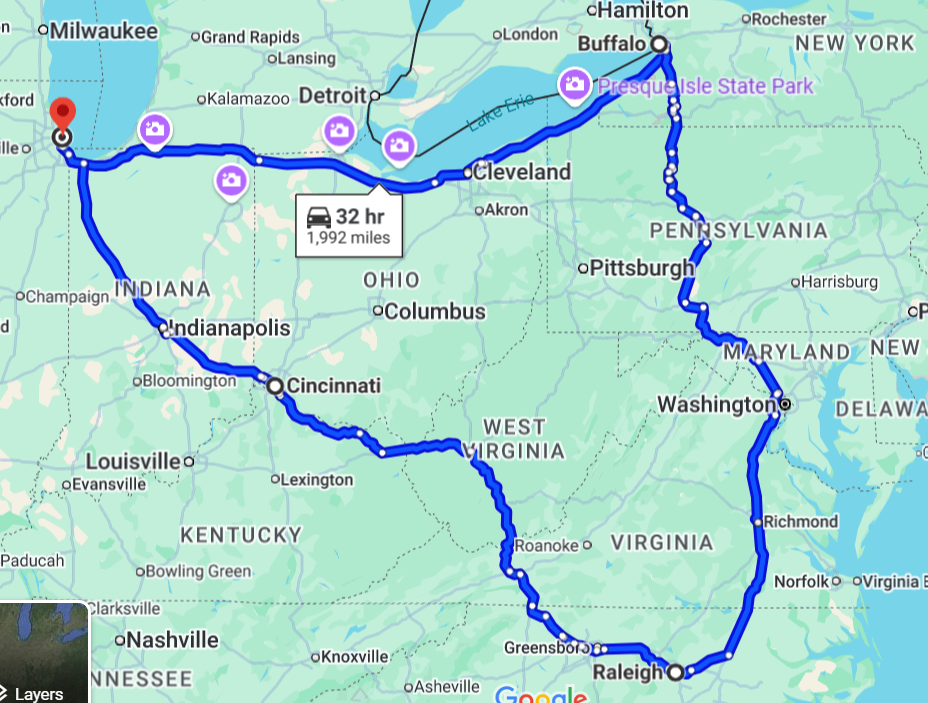

In [7]:
def polygon_coordinates(df: pd.DataFrame, cities_states: dict) -> list:
    """
    Extracts the coordinates for a geo_shape polygon from the specified cities and their corresponding states.
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - cities_states (dict): A dictionary with city names as keys and their corresponding states as values.
    Returns:
    - dict: A dictionary with the coordinates for the geo_shape polygon.
    """
    # Extract rows for the specified cities and their corresponding states
    polygon_df = df[
        df.apply(lambda row: row['CITY'] in cities_states and row['STATE_CODE'] == cities_states[row['CITY']], axis=1)
    ]

    # Extract coordinates for the geo_shape polygon
    coordinates = [row['GeoJSON']['coordinates'] for _, row in polygon_df.iterrows()]
    coordinates.append(coordinates[0])  # Close the polygon
    return [[coordinates]]

# BEGIN: Create geo_shape polygon for specified cities
cities_states = {
    'Chicago': 'IL',
    'Buffalo': 'NY',
    'Raleigh': 'NC',
    'Cincinatti': 'OH',
}

df_geo_shape = pd.DataFrame(columns=["city_states", "polygon_coordinates", "geo_shape"])
df_geo_shape["city_states"] = [cities_states] # direct assignment of dict is not allowed. Instead store as an array
df_geo_shape["polygon_coordinates"] = polygon_coordinates(df, cities_states)
df_geo_shape["geoshape_geojson"] = df_geo_shape.apply(lambda x: {"type": "polygon", "coordinates": x["polygon_coordinates"]}, axis=1)
df_geo_shape["ID"] = df_geo_shape.index
df_geo_shape = df_geo_shape[["ID","city_states", "geoshape_geojson"]]
df_geo_shape


,ID,city_states,geoshape_geojson
0,0,"{'Chicago': 'IL', 'Buffalo': 'NY', 'Raleigh': 'NC', 'Cincinatti': 'OH'}","{'type': 'polygon', 'coordinates': [[[-87.6866, 41.8375], [-78.6429, 35.8324], [-78.8487, 42.9018], [-87.6866, 41.8375]]]}"


In [197]:
# df_geo_shape.to_json(orient="records")

'[{"ID":0,"city_states":{"Chicago":"IL","Buffalo":"NY","Raleigh":"NC","Cincinatti":"OH"},"mygeoshape":{"type":"polygon","coordinates":[[[-87.6866,41.8375],[-78.6429,35.8324],[-78.8487,42.9018],[-87.6866,41.8375]]]}}]'

# Load my_geoshapes

In [8]:
from opensearchpy import OpenSearch
import json

# Initialize the OpenSearch client
os_client = OpenSearch(
  hosts=[{'host': '192.168.0.111', 'port': 9200}],
  use_ssl=False,
  verify_certs=False,
  ssl_assert_hostname=False,
  ssl_show_warn=False
)

# Define the index name
index_name = "locations"

# Define the mapping
mapping = {
  "mappings": {
  "properties": {
    "geoshape_geojson": {
    "type": "geo_shape"
    }
  }
  }
}

# Create the index with the specified mapping
os_client.indices.create(index=index_name, body=mapping)

# Bulk load documents into OpenSearch
bulk_load_documents(os_client, index_name, json.loads(df_geo_shape.to_json(orient="records")))


Successful operations: 1


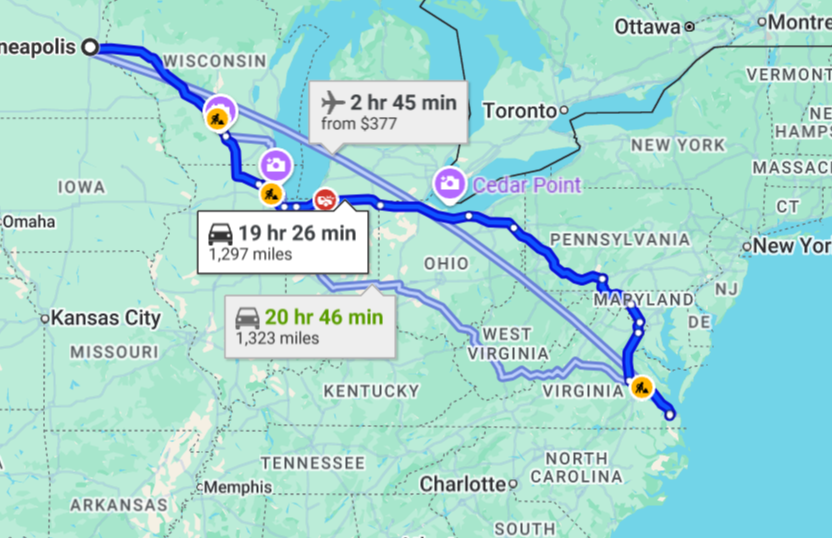

In [9]:
from IPython.display import display
minneapolis_norfolk_df = df[
  (df['CITY'] == 'Minneapolis') & (df['STATE_CODE'] == 'MN') |
  (df['CITY'] == 'Norfolk') & (df['STATE_CODE'] == 'VA')
]

# Set display options to show full row contents
pd.set_option('display.max_colwidth', None)
display(minneapolis_norfolk_df["GeoJSON"])
# Create a geo_bounding_box
geo_bounding_box = {
    "geoshape_geojson": {
    "top_left": minneapolis_norfolk_df["GeoJSON"].iloc[0]["coordinates"],
    "bottom_right": minneapolis_norfolk_df["GeoJSON"].iloc[1]["coordinates"]
}
}

print(geo_bounding_box)

QUERY =  {
  "query": {
    "bool": {
      "must": {
        "match_all": {}
      },
      "filter": {
        "geo_bounding_box": geo_bounding_box
      }
    }
  }
}

search_results = os_client.search(index="locations", body=QUERY, error_trace=True)

# Process search results
for hit in search_results["hits"]["hits"]:
    print(hit["_source"])
    print(hit["_score"])


15     {'type': 'Point', 'coordinates': [-93.2678, 44.9635]}
186     {'type': 'Point', 'coordinates': [-76.259, 36.8945]}
Name: GeoJSON, dtype: object

{'geoshape_geojson': {'top_left': [-93.2678, 44.9635], 'bottom_right': [-76.259, 36.8945]}}
{'ID': 0, 'city_states': {'Chicago': 'IL', 'Buffalo': 'NY', 'Raleigh': 'NC', 'Cincinatti': 'OH'}, 'geoshape_geojson': {'type': 'polygon', 'coordinates': [[[-87.6866, 41.8375], [-78.6429, 35.8324], [-78.8487, 42.9018], [-87.6866, 41.8375]]]}}
1.0



## Geo distance - closes geo_shapes

In [10]:
from IPython.display import display
# Raleigh to Charlotte geo-bounding box
# BEGIN: Get rows for Raleigh and Charlotte in NC
richmond_df = df[
  (df['CITY'] == 'Richmond') & (df['STATE_CODE'] == 'VA')
]

# Set display options to show full row contents
pd.set_option('display.max_colwidth', None)
display(richmond_df["GeoJSON"])
# Create a geo_bounding_box for Elasticsearch search
geo_distance = {
    "distance": "200mi",
    "geoshape_geojson": richmond_df.iloc[0]["GeoJSON"]["coordinates"]
}

print(geo_distance)

QUERY =  {
  "query": {
    "bool": {
      "must": {
        "match_all": {}
      },
      "filter": {
        "geo_distance": geo_distance
      }
    }
  }
}

search_results = os_client.search(index="locations", body=QUERY, error_trace=True)

# Process search results
for hit in search_results["hits"]["hits"]:
    print(hit["_source"])
    print(hit["_score"])


47    {'type': 'Point', 'coordinates': [-77.4756, 37.5295]}
Name: GeoJSON, dtype: object

{'distance': '200mi', 'geoshape_geojson': [-77.4756, 37.5295]}
{'ID': 0, 'city_states': {'Chicago': 'IL', 'Buffalo': 'NY', 'Raleigh': 'NC', 'Cincinatti': 'OH'}, 'geoshape_geojson': {'type': 'polygon', 'coordinates': [[[-87.6866, 41.8375], [-78.6429, 35.8324], [-78.8487, 42.9018], [-87.6866, 41.8375]]]}}
1.0
